## Settings

In [ ]:
!pip install simpletransformers
!pip install rouge_score
!pip install datasets
!pip install transformers


In [1]:
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/MyDrive/Projet_DL_yotta



Mounted at /content/drive
 apex			       data
'BART_HF code Antoine.ipynb'   drive
'BART_HF dorota.ipynb'	       model.ipynb
 BART_HF.ipynb		       notebooks_bart_fine_tune_colab.ipynb
'BARTSCISUM_V1 dp.ipynb'       notebooks_fine_tune.ipynb
 BART_ST.ipynb		       output_model
 cache_dir		       setup.py
 config_model		       test_tags_recover_1.ipynb


In [16]:
who = 'Dorota'
task ="title_generation"      # "title_generation" or "summary_generation"


In [ ]:
# installation de NVIDIA et download du repertoire si besoin

if who == 'Dorota':
  %cd /content/drive/MyDrive/Projet_DL_yotta
  #!git clone https://github.com/NVIDIA/apex
  %cd apex
  !ls
  !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
  %cd /content/drive/MyDrive/Projet_DL_yotta


## 1 Chargement des données

In [19]:
import pandas as pd

who = 'Dorota'

if who == 'Dorota':
  path_file = 'drive/MyDrive/Projet_DL_yotta/data/complete_articles_max_planck.csv'

data_mp = pd.read_csv(path_file, index_col=0)


from scisum.config import STANFORD, MAXPLANCK, HAL, DATA_DIR, MODELS_DIR
from scisum.config import TEXTS, SUMMARIES, PATH, FILENAME, TITLES, TAGS, DROP_FIRST
from scisum.config import MP_FRACTION, MP_RAND_STATE
from scisum.config import BART_MP_TITLE, PATH
data_mp = pd.read_csv(MAXPLANCK[PATH], index_col=0)

In [8]:
data_mp.head(2).T

0  \
title                                   Ventilation made easy   
date                                        December 01, 2020   
summary     In future, it will be far easier to remove inf...   
content     A simple ventilation system removes 90 percent...   
references                                                 []   
tags                                                      NaN   

                                                            1  
title                        Networks for memory and learning  
date                                        November 30, 2020  
summary     Memories are part of our lives, the good and t...  
content     Stable connections between nerve cells are the...  
references  ['Tim P. Castello-Waldow, Ghabiba Weston, Ales...  
tags                                                    Brain

In [20]:
data_mp.describe()

title            date  \
count                                    3032            3032   
unique                                   3030            2028   
top     Researching together in the Himalayas  April 10, 2019   
freq                                        2               6   

                                                  summary  \
count                                                2990   
unique                                               2990   
top     X-linked intellectual disability is a disorder...   
freq                                                    1   

                                                  content references  \
count                                                3032       3032   
unique                                               3032       2304   
top     Microscopic, synthetically manufactured protei...         []   
freq                                                    1        723   

                      tags  
count                 1011  
unique                 394  
top     Behavioral Biology  
freq                    51

Artcles > 200 words: 33 (1.1%)
Artcles < 15 words: 3 (0.1%)


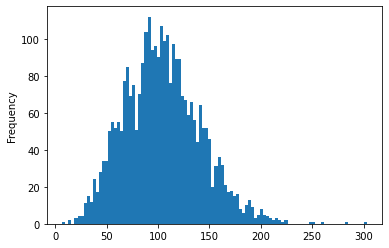

In [ ]:
words_counts = data_mp["summary"].dropna().str.split().apply(len)
words_counts.plot.hist(bins=100)
print(f"Artcles > 200 words: {len(words_counts[words_counts>200])} ({round(len(words_counts[words_counts>200])/len(data_mp)*100, 1)}%)")
print(f"Artcles < 15 words: {len(words_counts[words_counts<15])} ({round(len(words_counts[words_counts<15])/len(data_mp)*100, 1)}%)")

In [ ]:
# Selection d'un échantillon de la base (pour test uniquement!)

'''
fraction = 0.02
data_mp = data_mp.sample(frac=fraction, random_state=42)

print("nombre d'articles pour l'entrainement : ", len(data_mp),'\n')
'''

nombre d'articles pour l'entrainement :  61 



## 2 Préparation des données

In [21]:
def get_dataset(data,task='generate_title') :
  """ 
  Prepare the data of the Max Planck Institute for the training or the predict of summarization

  Parameters
  ----------
  data : Pandas DataFrame
        containing columns "title", "summary", "content" of articles
  task : str indicating which task we are working on
        "generate_title" - if we generate the title of the article
        "generate_lead_paragraph" - if we generate the summary of the article
        

  Returns
  -------
  dataset : Pandas DataFrame with 2 columns "input_text" and "target_text"
        "input_text" : The input text sequence
        "target_text" : The target text sequence

  """

  dataset = data.copy()

  if task=="title_generation":

    dataset = dataset.filter(items=['title','summary']).dropna()
    dataset = dataset.reindex(columns=['summary','title'])
    dataset = dataset.rename(columns={'summary':'input_text','title':'target_text'})


  if task=="summary_generation":

    dataset = dataset.filter(items=['summary','content']).dropna()
    dataset = dataset.reindex(columns=['content','summary'])
    dataset = dataset.rename(columns={'content':'input_text','summary':'target_text'})
  
  dataset = dataset.dropna()

  return dataset


In [13]:
def split_dataset(data, fraction=0.3, rand_state=42) :

  """ 
  split randomly the dataset into train and test sets

  Parameters
  ----------
  data : Pandas DataFrame
        containing 2 columns "input_text" and "target_text",   
  fraction : float between zero and 1
            indicating the size of the test set       

  Returns
  -------
  tuple with two Pandas DataFrames (train dataset, test dataset)
        "input_text" : The input text sequence
        "target_text" : The target text sequence

  """

  data_eval = data.sample(frac=fraction, random_state=rand_state)
  data_train = data.drop(data_eval.index)

  return (data_train, data_eval)


In [22]:
data = get_dataset(data_mp,task=task)
data.columns

#pd.set_option('display.max_colwidth', None)
#data.describe()

Index(['input_text', 'target_text'], dtype='object')

In [24]:
data_train, data_eval = split_dataset(data, fraction=0.03, rand_state=42)

pd.set_option('display.max_colwidth', None)
data_train.head(2).T

0  \
input_text   In future, it will be far easier to remove infectious aerosols from the air in classrooms and other spaces. Researchers at the Max Planck Institute for Chemistry have built a ventilation system that can be replicated using materials from a DIY store. A comprehensive school in Mainz has already tested the system. The Rhineland-Palatinate Ministry of Education is currently testing use of the system in other schools. A construction report is available online.   
target_text                                                                                                                                                                                                                                                                                                                                                                                                                                                         Ventilation made easy   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        1  
input_text   Memories are part of our lives, the good and the bad. Through our senses, experiences reach our brain where networks of nerve cells encode them into a memory. It was previously unclear why only certain nerve cells join together for this purpose. Researchers from the Max Planck Institute of Psychiatry in Munich have now discovered that stable connections of neurons are a support for memories to be generated. Flexible connections on the other hand were found to be responsible for learning.  
target_text                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Networks for memory and learning

In [25]:
print("nombre d'articles pour l'entrainement : ", len(data_train),'\n')
print("nombre d'articles pour l'eval : ", len(data_eval),'\n')

nombre d'articles pour l'entrainement :  2900 

nombre d'articles pour l'eval :  90 



## 3. Définition du model

In [28]:
# distilbart-cnn-12-6 for long summaries and distilbart-xsum-12-6 for short summaries

import logging
import pandas as pd
import torch

from simpletransformers.seq2seq import (
    Seq2SeqModel,
    Seq2SeqArgs,
)


In [30]:

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

nb_articles = len(data_train)

model_args = Seq2SeqArgs()
 
model_args.output_dir = 'drive/MyDrive/Projet_DL_yotta/output_model'
model_args.overwrite_output_dir = True     # Set to True to save the trained model to the ouput_dir
model_args.no_save = False   # If True, models will not be saved to disk.
model_args.tensorboard_dir = 'drive/MyDrive/Projet_DL_yotta/output_model/tensorboard'

model_args.save_eval_checkpoints = True      #Save a model checkpoint for every evaluation performed.
model_args.save_steps = -1                    #Save a model checkpoint at every specified number of steps. Set to -1 to disable.
model_args.save_model_every_epoch = False
model_args.save_optimizer_and_scheduler = False

model_args.num_train_epochs = 3
model_args.train_batch_size = 4	

# for generate summary, on enleve cette partie?
model_args.evaluate_during_training = True  # Set to True to perform evaluation while training models.
model_args.evaluate_during_training_verbose = True  # Print results from evaluation during training.
model_args.evaluate_during_training_steps = nb_articles
model_args.eval_batch_size = 1
model_args.evaluate_generated_text = True

model_args.logging_steps = nb_articles # Log training loss and learning at every specified number of steps.

model_args.p16 = True
model_args.silent = 1 # Disables progress bars, default False

#model_args.learning_rate= 4e-5	

if task=="title_generation":
    model_args.max_length = 15	#The max length of the sequence to be generated. Default to 20.
    model_args.max_seq_length = 250 # specifies the maximum number of tokens of the input. The number of token is superior or equal to the number of words of an input.

if task=='summary_generation':
    model_args.max_length = 200	#The max length of the sequence to be generated. Default to 20.
    model_args.max_seq_length = 1000 # specifies the maximum number of tokens of the input. The number of token is superior or equal to the number of words of an input.

# pour obtenir la liste des arguments
# model_args.get_args_for_saving()


In [31]:
# distilbart-xsum-12-6 for short summaries

model = Seq2SeqModel(
    encoder_decoder_type="bart",
    #encoder_decoder_name="sshleifer/distilbart-cnn-6-6",
    encoder_decoder_name="sshleifer/distilbart-xsum-6-6",
    args=model_args,
    use_cuda=True
)


ValueError: 'use_cuda' set to True when cuda is unavailable.Make sure CUDA is available or set `use_cuda=False`.

## 4. Entrainement

In [ ]:
model.train_model(data_train,
    output_dir = 'drive/MyDrive/Projet_DL_yotta/output_model',
    show_running_loss = True,
    eval_data=data_eval

 )

RuntimeError: ignored

## 5. Simulation de titre

In [4]:
input_text  = data_eval['input_text'].to_list()
target_text  = data_eval['target_text'].to_list()
#generated_text = model.predict(input_text)

n = min(len(data_train),10)

for i in range(n):

  print("input text :\n",input_text[i])
  print("target text :\n", target_text[i])
  generated_text = model.predict([input_text[i]])
  print("generated text:\n" ,generated_text,'\n')
   

NameError: name 'data_eval' is not defined